# Logistic Regression Challenge

In this challenge, we'll compare the success of "vanilla" logistic regression, ridge regression, and lasso regression as classifiers. We will work with census data available from the UCI repository. The dataset indluces 15 variables: for the dependent variable, we'll attempt to classify individuals' incomes as less than \$50,000 or greater than or equal to \$50,000. The independent variables in the dataset include demogrpahic characteristics, census sampling weight, capital gains and losses, hours of work per week, and country of origin. 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
import numpy as np
import math
import statsmodels.api as sm

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Read in the data.
df = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/adult_data.csv', encoding='utf-8')
print(len(df))
df.head()

32561


,Age,WorkClass,fnwgt,Education,EducationNum,Marital,Occupation,Relationship,Race,Sex,CapGain,CapLoss,Hrs,Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data cleaning and feature exploration

The dependent variable is not composed of balanced classes: approxmiately three times as many individuals earn less than 50k than earn more than 50k.

In [3]:
#Inspect outcome variable.
df['Income'].value_counts()
df['Income'] = np.where(df['Income']=='<=50K', 0, 1)

There do not appear to be any missing values; however, the 99999 maximum in Capital Gains is suspicious--it may represent missing values.

**NOTE, I cannot figure out how to get these models to handle missing values, so I've reset the 99999s to 0s, rather than NaNs. I'd like to learn how to deal with this issue. 

In [4]:
for col in df.columns:
    print(df[col].describe())

count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: Age, dtype: float64
count       32561
unique          9
top       Private
freq        22696
Name: WorkClass, dtype: object
count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnwgt, dtype: float64
count       32561
unique         16
top       HS-grad
freq        10501
Name: Education, dtype: object
count    32561.000000
mean        10.080679
std          2.572720
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         16.000000
Name: EducationNum, dtype: float64
count                  32561
unique                     7
top       Married-civ-spouse
freq                   14976
Name: Marital, dtype: object
count              32561
unique 

In [5]:
#Check CapGain for anomalies.
df['CapGain'] = df['CapGain'].sort_values()
df['CapGain'].value_counts()

#Drop 99999 as missing.
df[df['CapGain'] == 99999] = 0
df['CapGain'].describe()

count    32561.000000
mean       589.339486
std       2554.334160
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      41310.000000
Name: CapGain, dtype: float64

The continuous variables show a few different distributions. Age is slightly right-skewed and sampling weight is extremely right-skewed. Capital gains and losses are primarily made up of 0 values. 

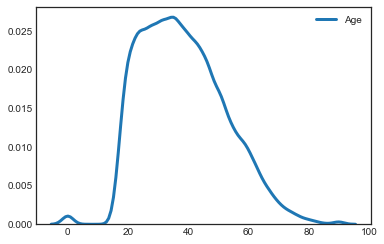

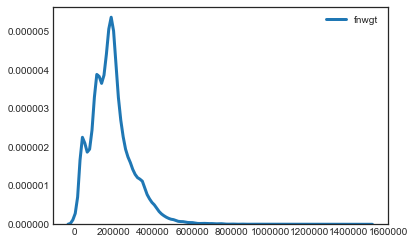

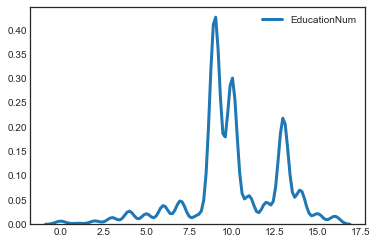

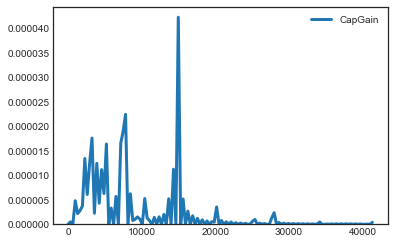

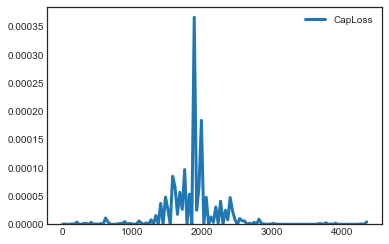

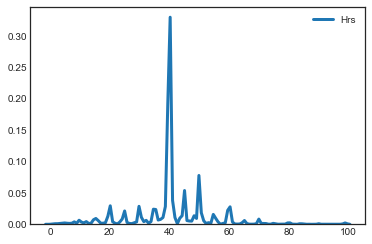

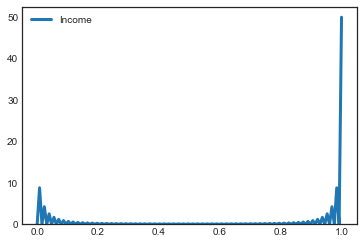

In [6]:
df_num = df._get_numeric_data()
for col in df_num.columns:
    sns.kdeplot(df_num[col], lw=3)
    plt.show()

                   Age     fnwgt  EducationNum   CapGain   CapLoss       Hrs  \
Age           1.000000 -0.050731      0.082730  0.117427  0.060350  0.108016   
fnwgt        -0.050731  1.000000     -0.008782 -0.002457 -0.008271  0.008906   
EducationNum  0.082730 -0.008782      1.000000  0.144804  0.082635  0.194234   
CapGain       0.117427 -0.002457      0.144804  1.000000 -0.049989  0.084457   
CapLoss       0.060350 -0.008271      0.082635 -0.049989  1.000000  0.057270   
Hrs           0.108016  0.008906      0.194234  0.084457  0.057270  1.000000   
Income        0.234391 -0.004889      0.328134  0.311083  0.154081  0.228534   

                Income  
Age           0.234391  
fnwgt        -0.004889  
EducationNum  0.328134  
CapGain       0.311083  
CapLoss       0.154081  
Hrs           0.228534  
Income        1.000000  


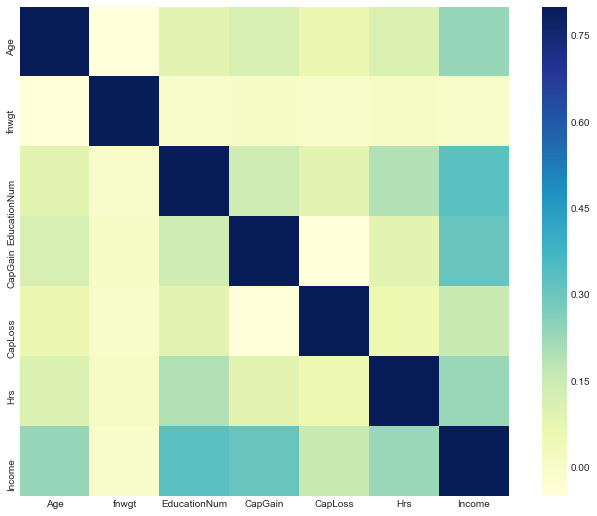

In [7]:
# Make the correlation matrix.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=0.8, square=True, cmap="YlGnBu")
plt.show()

In [8]:
pd.crosstab([df['Sex'], df['Race']], df['Income'], margins=True)

Income                         0     1    All
Sex    Race                                  
0      0                     159     0    159
Female Amer-Indian-Eskimo    107    12    119
       Asian-Pac-Islander    303    41    344
       Black                1465    86   1551
       Other                 103     6    109
       White                7614  1012   8626
Male   Amer-Indian-Eskimo    168    24    192
       Asian-Pac-Islander    460   225    685
       Black                1272   294   1566
       Other                 143    17    160
       White               13085  5965  19050
All                        24879  7682  32561

In [9]:
df['WhiteMale'] = np.where((df['Sex']=='Male') & (df['Race']=='White'), 1, 0)
df['WhiteMale'].value_counts()

1    19050
0    13511
Name: WhiteMale, dtype: int64

In [10]:
#df['Immigrant'] = 1
df['Immigrant'] = np.where(df['Country']=='United-States', 0, 1)
df['Immigrant'].value_counts()

0    29028
1     3533
Name: Immigrant, dtype: int64

To accommodate the preponderance of zero values in the capital gains and losses variables, let's add binary variables and then drop the zeros in the continuous versions of the variables, imputing them with the median.

**NOTE: I tried dropping the zeros, but then I couldn't run the model; dropping NaN wasn't successful. I also tried imputing the zeros with the median, as in two cells below (with a few different strategies), but that had the effect of changing all categorical values in the dataset to NaNs, so I've left the zeros in place for now.**

In [11]:
#df.loc[df['CapLoss'] == 0] = None
#df.loc[df['CapGain'] == 0] = None
#df = df.fillna(df.median())

In [12]:
df['Investor'] = np.where((df['CapGain']>0) | (df['CapLoss']>0), 1, 0)
df['Investor'].value_counts()

0    28489
1     4072
Name: Investor, dtype: int64

In [13]:
X = []
X = df.drop('Income', 1)
X = pd.get_dummies(X)
X = StandardScaler().fit_transform(X)
y = df['Income']

### Vanilla Logistic Regression

In [14]:
# Declare and fit the model.
lr = LogisticRegression(C=1e9)

# Fit the model.
fit = lr.fit(X, y)
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

# Cross-validate.
score = cross_val_score(lr, X, y, cv=5)

print('\n Accuracy scores:')
print(score)
print('\n Average score:')
print(sum(score)/5)

Coefficients
[[  3.54612160e-01   7.70102328e-02   4.34489673e-01   1.76828797e+00
    7.47333659e-01   3.71635558e-01  -5.67107441e-02  -5.15496358e-02
   -7.99197600e-01  -2.36204815e-02  -6.21956937e-02   1.07040301e-01
   -7.39380666e-03  -1.10040237e-01   6.11530434e-02   5.24467924e-02
   -9.41588106e-02  -3.63976922e-02  -1.93560340e-01  -2.36204815e-02
   -6.70503518e-02  -9.80480763e-02  -2.91198452e-02  -2.54543185e-02
   -1.83155437e-02  -6.88778991e-02  -4.68996291e-02  -1.24569238e-02
    2.74771867e-02   1.38135406e-01   1.03033624e-01  -3.70251542e-02
    1.25471598e-01  -1.38203252e+00   1.14692851e-01   4.15511167e-02
   -2.36204815e-02  -2.36075453e-01   5.56348496e-02   7.93631216e-01
   -7.91324357e-02  -5.58184959e-01  -1.50336716e-01  -9.90381183e-02
   -2.36204815e-02  -6.90728317e-02   5.19846112e-04  -1.90161962e-02
    2.25646360e-02   2.56084200e-01  -1.71766691e-01  -1.33716759e-01
   -5.87625174e-02  -2.51839933e-01  -5.12246042e-01   1.66545743e-01
    7.8

### Ridge Logistic Regression

In [15]:
# Declare and fit the ridge model.

ridge = LogisticRegression(penalty='l2', C=50, fit_intercept=False)

fit = ridge.fit(X, y)

print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

score = cross_val_score(ridge, X, y, cv=5)

print('\n Accuracy scores:')
print(score)
print('\n Average score:')
print(sum(score)/5)

Coefficients
[[  2.23054292e-01   6.12662027e-02   2.43673439e-01   9.71490646e+00
    3.18911421e+00   2.43304896e-01   4.17242610e-02  -2.32059992e-02
   -4.61257751e+00   1.40563788e-02  -3.92798094e-02   7.91889719e-02
   -2.35832671e-02  -8.66844385e-04   4.01198147e-02   6.30734840e-02
   -8.05509199e-02  -3.68842541e-02  -2.87848100e-02   1.40563788e-02
   -4.89629456e-02  -6.19598325e-02  -1.90565840e-02  -1.94809743e-02
   -3.48208127e-02  -6.64138111e-02  -3.92506270e-02  -2.15438968e-02
   -7.71593178e-03   1.03112850e-01   1.40491365e-01  -1.07342258e-01
    1.30724008e-01  -2.86503877e-02   1.48835388e-01  -1.18056271e-02
    1.40563788e-02  -8.23987128e-02   2.52380417e-02   2.52075179e-01
   -1.10663410e-02  -1.80348621e-01  -5.37268508e-02  -2.13644475e-02
    1.40563788e-02  -3.92644991e-02  -2.01828197e-02  -1.24281518e-02
   -3.68695251e-02   2.01245837e-01  -1.39147309e-01  -9.33197132e-02
   -7.69577898e-02  -9.31664669e-02  -1.50598319e-02   9.33547572e-02
    4.7

### Lasso Logistic Regression

In [16]:
# Declare and fit the ridge model.

lasso = LogisticRegression(penalty='l1', C=5, fit_intercept=False)

fit = lasso.fit(X, y)

print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

score = cross_val_score(lasso, X, y, cv=5)

print('\n Accuracy scores:')
print(score)
print('\n Average score:')
print(sum(score)/5)

Coefficients
[[  2.22954468e-01   6.11877362e-02   4.78347660e-01   9.71305987e+00
    3.18833224e+00   2.43211146e-01   4.20716960e-02  -5.97678081e-03
   -4.61139751e+00   0.00000000e+00  -4.57083539e-02   6.89710178e-02
   -3.82600309e-02  -1.18712187e-03   1.23578024e-02   5.22726002e-02
   -9.65615310e-02  -4.85964020e-02  -2.99426431e-02   0.00000000e+00
    9.11328633e-03  -1.33255641e-02   5.76565387e-04   3.07654902e-02
    2.68821490e-02   6.83663374e-03   1.51291890e-02  -5.38334334e-02
   -2.64712426e-02   3.25220450e-03   8.13586222e-02  -6.82548786e-02
    5.07796595e-02   2.48562365e-03   9.22027579e-02  -1.37829660e-02
    2.10161246e-03  -1.08523540e-01   2.31790557e-02   2.13980378e-01
   -1.95877254e-02  -2.16128655e-01  -6.69638006e-02  -3.44271858e-02
    7.75911392e-02  -2.09914171e-02   1.52906886e-02  -1.05134651e-02
    0.00000000e+00   2.37797450e-01  -1.19957746e-01  -7.09414597e-02
   -5.02081250e-02  -5.95961362e-02  -7.44782862e-03   1.30113908e-01
    6.3

### Discussion

For this classification exercise, three approaches to logistic regression were compared. All three models had accuracy rates consistently around 85%. 

For this dataset, ridge regression may be the best approach, because it is designed to protect against overfitting. I noticed, however, that some of the coefficients are actually larger in the ridge regression than in the vanilla regression. Why is this the case?

Lasso regression eliminates 6 features, so it eliminates some noise from the dataset and prevents potentially meaningless features from contributing to overfitting. 